### Data 620 - Project 2
### Leticia Salazar
### March 5, 2023

#### Task:

1. Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
2. Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
3. What can you infer about each of the distinct groups?

#### Data source:

We decided to continue working with our project 1 dataset since it's a 2 node network to further explore the dataset and be able to create better visualizations. This dataset was obtained from [Network Repository](https://networkrepository.com/socfb-Cornell5.php) consisting of people (nodes) and their friendship ties (edges) on Facebook. The data is available in a matrix market, typically a sparse format used to represent a matrix (.mtx file). With these types of files, the first line contains a header with information about the matrix, dimensions, and symmetry of the matrix. The following lines are non-zero entries of the matrix in row-major order, with each following line containing the row index, column index, and a value of a single non-zero entry.

Below are some specs from this dataset provided by the repository:

* Nodes: 18.7K
* Edges: 790.8K
* Density: 0.00454239
* Maximum degree: 3.2K
* Minimum degree: 1
* Average degree: 84
* Assortativity: 0.01805
* Number of triangles: 18.3M
* Average number of triangles: 982
* Maximum number of triangles: 77.2K
* Average clustering coefficient: 0.219051
* Fraction of closed triangles: 0.135615
* Maximum k-core: 85
* Lower bound of Maximum Clique: 13

#### Load libraries:

Below are the libraries used

In [35]:
# data manipulation
import pandas as pd
import numpy as np
from tqdm import tqdm #Instantly make your loops show a smart progress meter 
import random 
from scipy import stats

# data visualization
import networkx as nx
import matplotlib.pyplot as plt
from networkx_viewer import Viewer

# Import bi-partite (bi-modal) functions
from networkx.algorithms import bipartite as bi
import networkx as net

#### Load the data:
As mentioned, the original file had to be split to a smaller size containing 27000 variables only.

In [19]:
df = pd.read_csv('https://raw.githubusercontent.com/letisalba/Data-620/master/Week-7/fb_split.csv')
df.head(10)

,Person,Friendships
0,184,1
1,344,1
2,635,1
3,867,1
4,1296,1
5,1358,1
6,1425,1
7,1501,1
8,1505,1
9,1845,1


In [20]:
df.Person.nunique()

11138

In [21]:
df.shape

(27000, 2)

In [22]:
df.Person.value_counts()

9651     60
17027    58
16112    38
4482     32
12797    29
         ..
9583      1
6531      1
1798      1
409       1
12004     1
Name: Person, Length: 11138, dtype: int64

In [ ]:
# Filtering all the friendship nodes by merging with original dataset

In [25]:
# start networkX 
G = nx.Graph()
G.add_nodes_from(df)

for i, elrow in df.iterrows():
    G.add_node(elrow[0])
    G.add_node(elrow[1])

    if G.has_edge(elrow[0], elrow[1]):
            # edge already exists, increase weight by one
            G[elrow[0]][elrow[1]]['weight'] += 1
    else:
            # add new edge with weight 1
            G.add_edge(elrow[0], elrow[1], weight = 1)


G_nodes = G.number_of_nodes()
G_edges = G.number_of_edges()
print("The number of nodes = ", G_nodes, " The number of edges = ", G_edges)

The number of nodes =  11347  The number of edges =  27000


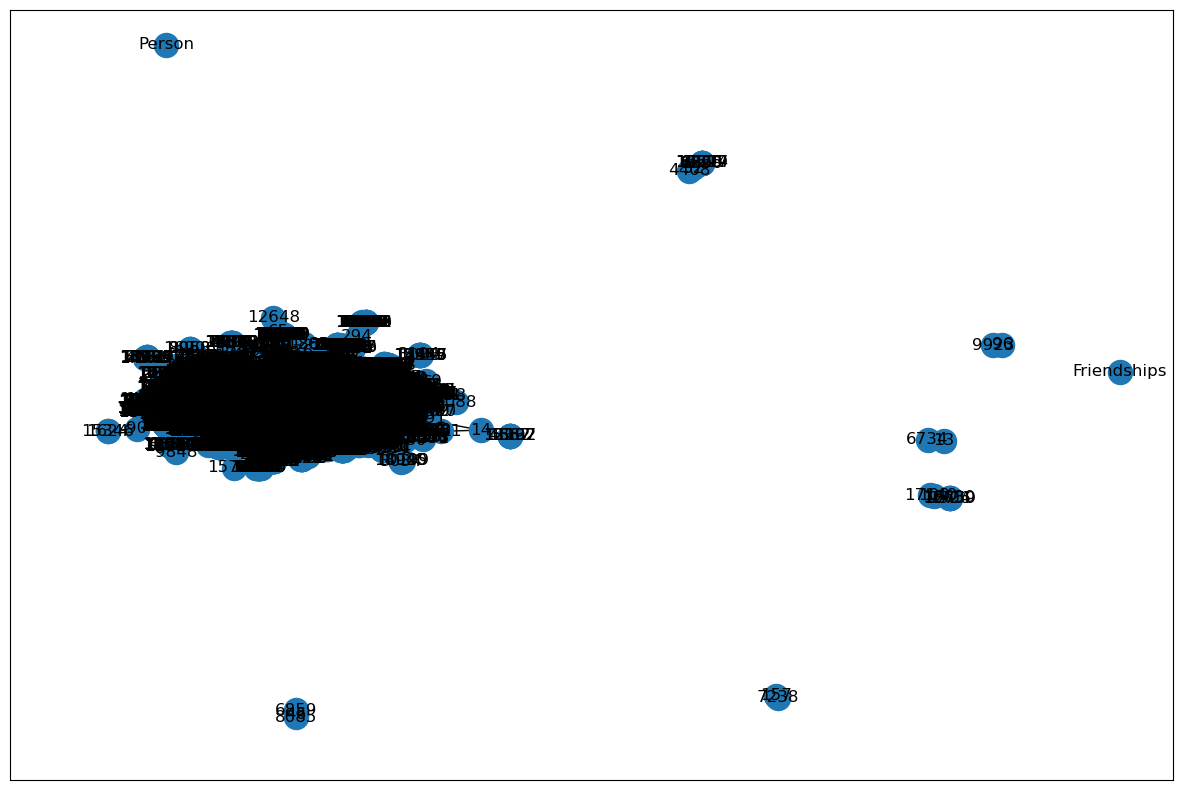

In [26]:
plt.figure(figsize=(15,10))
nx.draw_networkx(G)
plt.show()

In [27]:
fb = nx.read_edgelist("facebook_comb_split2.txt", create_using = nx.Graph(), nodetype=int)
print(nx.info(fb))

Graph with 11345 nodes and 27000 edges


/var/folders/xs/s7qlj6l16qj7704tpbyx6rr80000gn/T/ipykernel_26363/235781926.py:2: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(fb))


In [29]:
# start networkX 
G_2 = nx.Graph()
G_2.add_nodes_from(fb)

for i, elrow in df.iterrows():
    G_2.add_node(elrow[0])
    G_2.add_node(elrow[1])

    if G_2.has_edge(elrow[0], elrow[1]):
            # edge already exists, increase weight by one
            G_2[elrow[0]][elrow[1]]['weight'] += 1
    else:
            # add new edge with weight 1
            G_2.add_edge(elrow[0], elrow[1], weight = 1)


G_2_nodes = G_2.number_of_nodes()
G_2_edges = G_2.number_of_edges()
print("The number of nodes = ", G_2_nodes, " The number of edges = ", G_2_edges)

The number of nodes =  11345  The number of edges =  27000


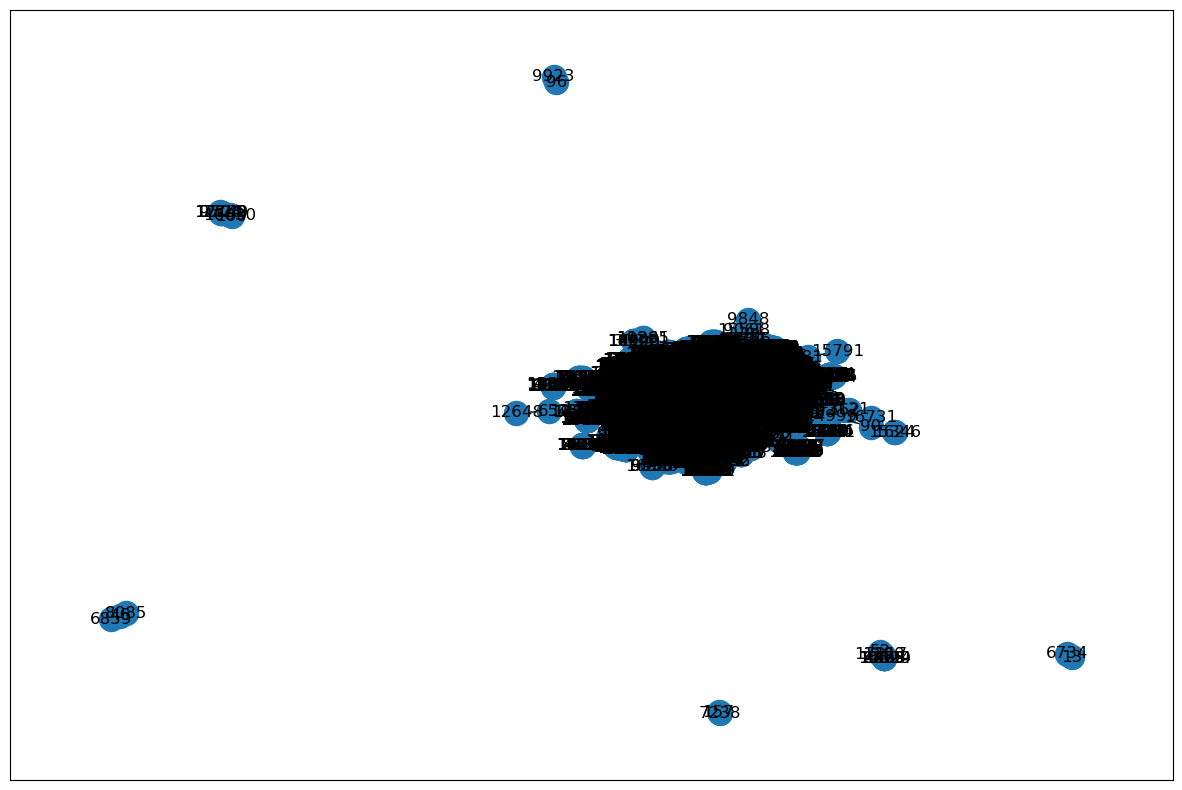

In [30]:
plt.figure(figsize=(15,10))
nx.draw_networkx(G_2)
plt.show()

In [38]:
# 2-mode graphs are usually directed. Here, their direction implies money flow
g=net.Graph()

# we need to keep track separately of nodes of all types
Person=[]
Friendships=[]

# Construct a directed graph from edges in the CSV file
for row in df:
    if row[0] not in Person:
        Person.append(row[0])
    if row[12] not in Friendships:
        Friendships.append(row[12])
    g.add_edge(row[0],row[12], weight=int(row[10]))

IndexError: string index out of range

In [40]:
#pacnet=bi.weighted_projected_graph(g, pacs, ratio=False)
#pacnet=net.connected_component_subgraphs(pacnet)[0]
#weights=[math.log(edata['weight']) for f,t,edata in pacnet.edges(data=True)]


cannet=bi.weighted_projected_graph(G, Friendships, ratio=False)
cannet=net.connected_component_subgraphs(cannet)[0]
weights=[math.log(edata['weight']) for f,t,edata in cannet.edges(data=True)]
net.draw_networkx(cannet,width=weights, edge_color=weights)

AttributeError: module networkx has no attribute connected_component_subgraphs

In [ ]:
def trim_edges(g, weight=1):
        g2=net.Graph()
        for f, to, edata in g.edges(data=True):
                if edata['weight'] > weight:
plot.hist(weights)

# The weights histogram is logarithmic;
# we should compute the original weight = e^log_weight
cannet_trim=trim_edges(cannet, weight=math.exp(0.9))

# re-calculate weights based on the new graph
weights=[edata['weight'] for f,t,edata in cannet_trim.edges(data=True)]
net.draw_networkx(cannet_trim,width=weights, edge_color=weights)

In [41]:
from networkx.algorithms import bipartite
B = nx.path_graph(4)
G = bipartite.projected_graph(B, [1, 3])
list(G)
list(G.edges())

[(1, 3)]

In [42]:
B = nx.Graph()
B.add_edges_from(G)
G = bipartite.projected_graph(B, ["a", "b"], multigraph=True)
print([sorted((u, v)) for u, v in G.edges()])

TypeError: object of type 'int' has no len()

In [ ]:
# Borrowed from SNAS Chapter 4
def trim_edges(g, weight=1): 
    g2=nx.Graph()
    for f, to, edata in g.edges(data=True): 
        if edata['weight'] > weight:
            g2.add_edge(f,to,edata)
    return g2

In [ ]:
# Borrowed from SNAS Chapter 4
def island_method(g, iterations=5):
    weights = [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn = int(min(weights))
    mx = int(max(weights))
    step = int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]


In [ ]:
islands = island_method(B)
for i in islands:
    print i[0], len(i[1])


In [ ]:
B2 = trim_edges(B, 13)
plt.figure(figsize = (10,10))
weights = [edata['weight'] for f,t,edata in B2.edges(data=True)]
nx.draw_networkx(B2, width=weights, edge_color=weights)

In [ ]:
B3 = trim_edges(B, 17)
plt.figure(figsize = (10,10))
weights = [edata['weight'] for f,t,edata in B3.edges(data=True)]
nx.draw_networkx(B3)
B3.edges(data=True)
